# 01: Basic Graph Construction with gPIE

This notebook demonstrates the basic workflow of **gPIE** (Graph-based Probabilistic Inference Engine), a modular framework for structured probabilistic inference using **Expectation Propagation (EP)** on factor graphs.

In this example, we will model and solve a **simple compressed sensing problem**:
- We define a **sparse latent signal** as a probabilistic prior.
- We model measurements as a **masked Fourier transform** with additive Gaussian noise.
- We use EP to infer the latent signal from noisy, subsampled observations.

This example introduces the core components of gPIE:
- **Waves:** latent variables representing probabilistic quantities.
- **Factors:** priors, propagators (e.g., FFT), and measurements linked together to form a factor graph.
- **EP inference:** iterative message passing over the factor graph to approximate posterior beliefs.

By the end of this notebook, you will learn how to:
1. Construct a factor graph using `Wave` variables and factor nodes.
2. Generate synthetic data samples from the graph.
3. Run EP inference and monitor reconstruction error.
4. Visualize the reconstructed signal.

This minimal example serves as a foundation for more complex imaging models such as:
- Holography
- Coded Diffraction Patterns (CDP) 
- Coherent Diffractive Imaging (CDI) with Layered Optics
- Ptychography

### Setup

In [38]:
import numpy as np
from numpy.random import default_rng
import gpie
gpie.set_backend(np)

from gpie import Graph, SparsePrior, GaussianMeasurement, fft2, mse
from gpie.core.linalg_utils import random_binary_mask

### Parameters

In [39]:
shape = (256, 256)
rho = 0.1         # sparsity
var = 1e-4        # noise variance
mask_ratio = 0.3  # subsampling rate

rng_init_ = default_rng(seed=12) # used for initialization of EP
rng_sample = default_rng(seed = 999) # used for generating synthetic data
mask = random_binary_mask(shape, subsampling_rate=mask_ratio, rng=rng_sample)

### Factor Graph

In [40]:
class CompressedSensing(Graph):
    def __init__(self, rho, var, mask):
        super().__init__()
        x = ~SparsePrior(shape=mask.shape, rho=rho, label="x")
        with self.observe():
            y = GaussianMeasurement(var=var, mask = mask) @  fft2(x)
        self.compile()

g = CompressedSensing(rho, var, mask)

### Generating Synthetic Data

In [41]:
g.set_init_rng(rng_init_)
g.generate_sample(rng_sample, update_observed=True) # use the generated sample as the observation
true_x = g.get_wave("x").get_sample()

### Inference & Monitoring

In [42]:
def monitor(graph, t):
    est = graph.get_wave("x").compute_belief().data
    err = mse(est, true_x)
    if t % 5 == 0:
        print(f"[t={t}] MSE = {err:.5e}")

g.run(n_iter=30, callback=monitor)

[t=0] MSE = 4.28449e-01
[t=5] MSE = 5.90966e-03
[t=10] MSE = 6.39331e-05
[t=15] MSE = 4.73173e-05
[t=20] MSE = 4.73182e-05
[t=25] MSE = 4.73178e-05


### Plot

Final MSE: 4.73178e-05


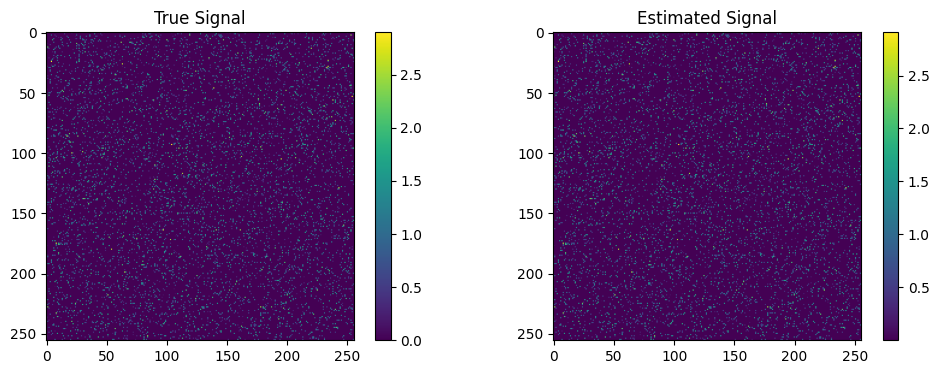

In [43]:
import matplotlib.pyplot as plt

final_est = g.get_wave("x").compute_belief().data
print(f"Final MSE: {mse(final_est, true_x):.5e}")

plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.imshow(np.abs(true_x)); plt.title("True Signal"); plt.colorbar()
plt.subplot(1,2,2); plt.imshow(np.abs(final_est)); plt.title("Estimated Signal"); plt.colorbar()
plt.show()